# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install h2o


    100% |████████████████████████████████| 142.8MB 247kB/s eta 0:00:01 3% |█▎                              | 5.5MB 35.5MB/s eta 0:00:04    12% |████▏                           | 18.5MB 29.2MB/s eta 0:00:05    13% |████▌                           | 19.8MB 27.5MB/s eta 0:00:05    16% |█████▍                          | 24.0MB 29.8MB/s eta 0:00:04    18% |██████                          | 26.8MB 31.0MB/s eta 0:00:04    21% |███████                         | 30.9MB 26.9MB/s eta 0:00:05    26% |████████▍                       | 37.5MB 27.2MB/s eta 0:00:04    28% |█████████▎                      | 41.3MB 27.0MB/s eta 0:00:04    30% |█████████▉                      | 43.8MB 24.1MB/s eta 0:00:05    33% |██████████▋                     | 47.6MB 26.8MB/s eta 0:00:04    34% |███████████                     | 48.8MB 22.0MB/s eta 0:00:05    36% |███████████▊                    | 52.5MB 25.3MB/s eta 0:00:04    38% |████████████▎                   | 54.9MB 25.4MB/s eta 0:00:04    43% |██████████████ 

In [110]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import lightgbm as lgb
import joblib

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [43]:
# Choose number of rows to load in for rapid iteration

azdias_rows = 10000     # Set equal to 891211 to load all azdias rows
cust_rows = 2000         # Set equal to 191652 to load all customers rows

year = 2015              # Set equal to year data was collected

# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows = azdias_rows)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows = cust_rows)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [45]:
categorical_col_names = """AGER_TYP
ALTER_HH
ALTERSKATEGORIE_GROB
ANREDE_KZ
BIP_FLAG
CAMEO_DEU_2015
CAMEO_INTL_2015
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_KK_KUNDENTYP
D19_KONSUMTYP
D19_LETZTER_KAUF_BRANCHE
FINANZTYP
GEBAEUDETYP
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HAUSHALTSSTRUKTUR
HEALTH_TYP
KBA05_HERSTTEMP
KBA05_MAXHERST
KBA05_MODTEMP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
OST_WEST_KZ
PRAEGENDE_JUGENDJAHRE
REGIOTYP
SHOPPER_TYP
SOHO_FLAG
TITEL_KZ
VERS_TYP
ZABEOTYP"""

non_categorical_col_names = """ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
ANZ_PERSONEN
ANZ_TITEL
BALLRAUM
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_REST_RZ
D19_TIERARTIKEL_RZ
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSAND_REST_RZ
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
D19_VERSICHERUNGEN_RZ
D19_VOLLSORTIMENT_RZ
D19_WEIN_FEINKOST_RZ
EWDICHTE
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP_RASTER
GEBURTSJAHR
GEOSCORE_KLS7
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA05_GBZ
KBA05_HERST1
KBA05_HERST2
KBA05_HERST3
KBA05_HERST4
KBA05_HERST5
KBA05_KRSAQUOT
KBA05_KRSHERST1
KBA05_KRSHERST2
KBA05_KRSHERST3
KBA05_KRSKLEIN
KBA05_KRSOBER
KBA05_KRSVAN
KBA05_KRSZUL
KBA05_KW1
KBA05_KW2
KBA05_KW3
KBA05_MAXAH
KBA05_MAXBJ
KBA05_MAXSEG
KBA05_MAXVORB
KBA05_MOD1
KBA05_MOD2
KBA05_MOD3
KBA05_MOD4
KBA05_MOD8
KBA05_MOTOR
KBA05_MOTRAD
KBA05_SEG1
KBA05_SEG10
KBA05_SEG2
KBA05_SEG3
KBA05_SEG4
KBA05_SEG5
KBA05_SEG6
KBA05_SEG7
KBA05_SEG8
KBA05_SEG9
KBA05_VORB0
KBA05_VORB1
KBA05_VORB2
KBA05_ZUL1
KBA05_ZUL2
KBA05_ZUL3
KBA05_ZUL4
KBA13_ALTERHALTER_30
KBA13_ALTERHALTER_45
KBA13_ALTERHALTER_60
KBA13_ALTERHALTER_61
KBA13_ANZAHL_PKW
KBA13_AUDI
KBA13_AUTOQUOTE
KBA13_BJ_1999
KBA13_BJ_2000
KBA13_BJ_2004
KBA13_BJ_2006
KBA13_BJ_2008
KBA13_BJ_2009
KBA13_BMW
KBA13_CCM_0_1400
KBA13_CCM_1000
KBA13_CCM_1200
KBA13_CCM_1400
KBA13_CCM_1400_2500
KBA13_CCM_1500
KBA13_CCM_1600
KBA13_CCM_1800
KBA13_CCM_2000
KBA13_CCM_2500
KBA13_CCM_2501
KBA13_CCM_3000
KBA13_CCM_3001
KBA13_FAB_ASIEN
KBA13_FAB_SONSTIGE
KBA13_FIAT
KBA13_FORD
KBA13_HALTER_20
KBA13_HALTER_25
KBA13_HALTER_30
KBA13_HALTER_35
KBA13_HALTER_40
KBA13_HALTER_45
KBA13_HALTER_50
KBA13_HALTER_55
KBA13_HALTER_60
KBA13_HALTER_65
KBA13_HALTER_66
KBA13_HERST_ASIEN
KBA13_HERST_AUDI_VW
KBA13_HERST_BMW_BENZ
KBA13_HERST_EUROPA
KBA13_HERST_FORD_OPEL
KBA13_HERST_SONST
KBA13_KMH_0_140
KBA13_KMH_110
KBA13_KMH_140
KBA13_KMH_140_210
KBA13_KMH_180
KBA13_KMH_211
KBA13_KMH_250
KBA13_KMH_251
KBA13_KRSAQUOT
KBA13_KRSHERST_AUDI_VW
KBA13_KRSHERST_BMW_BENZ
KBA13_KRSHERST_FORD_OPEL
KBA13_KRSSEG_KLEIN
KBA13_KRSSEG_OBER
KBA13_KRSSEG_VAN
KBA13_KRSZUL_NEU
KBA13_KW_0_60
KBA13_KW_110
KBA13_KW_120
KBA13_KW_121
KBA13_KW_30
KBA13_KW_40
KBA13_KW_50
KBA13_KW_60
KBA13_KW_61_120
KBA13_KW_70
KBA13_KW_80
KBA13_KW_90
KBA13_MAZDA
KBA13_MERCEDES
KBA13_MOTOR
KBA13_NISSAN
KBA13_OPEL
KBA13_PEUGEOT
KBA13_RENAULT
KBA13_SEG_GELAENDEWAGEN
KBA13_SEG_GROSSRAUMVANS
KBA13_SEG_KLEINST
KBA13_SEG_KLEINWAGEN
KBA13_SEG_KOMPAKTKLASSE
KBA13_SEG_MINIVANS
KBA13_SEG_MINIWAGEN
KBA13_SEG_MITTELKLASSE
KBA13_SEG_OBEREMITTELKLASSE
KBA13_SEG_OBERKLASSE
KBA13_SEG_SONSTIGE
KBA13_SEG_SPORTWAGEN
KBA13_SEG_UTILITIES
KBA13_SEG_VAN
KBA13_SEG_WOHNMOBILE
KBA13_SITZE_4
KBA13_SITZE_5
KBA13_SITZE_6
KBA13_TOYOTA
KBA13_VORB_0
KBA13_VORB_1
KBA13_VORB_1_2
KBA13_VORB_2
KBA13_VORB_3
KBA13_VW
KKK
KONSUMNAEHE
MIN_GEBAEUDEJAHR
MOBI_REGIO
ONLINE_AFFINITAET
ORTSGR_KLS9
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_GBZ
PLZ8_HHZ
RELAT_AB
RETOURTYP_BK_S
SEMIO_DOM
SEMIO_ERL
SEMIO_FAM
SEMIO_KAEM
SEMIO_KRIT
SEMIO_KULT
SEMIO_LUST
SEMIO_MAT
SEMIO_PFLICHT
SEMIO_RAT
SEMIO_REL
SEMIO_SOZ
SEMIO_TRADV
SEMIO_VERT
W_KEIT_KIND_HH
WACHSTUMSGEBIET_NB
WOHNDAUER_2008
WOHNLAGE"""



In [46]:
cat_col_list = categorical_col_names.split('\n')
non_cat_col_list = non_categorical_col_names.split('\n')
cat_col = [x for x in cat_col_list if x in azdias.columns]
non_cat_col = [x for x in non_cat_col_list if x in azdias.columns]
col_list = cat_col + non_cat_col
print('Number of features described in Excel Workbook: ', len(col_list))

Number of features described in Excel Workbook:  274


In [47]:
def preprocessing(dataframe):
    
    print('- '*25)
        
    try:
        Class = dataframe['RESPONSE']
    except:
        Class = -1
        
    try:
        dataframe.drop(columns = ['RESPONSE'])
    except: 
        pass
        
    print('Replacing all "NaN" with -1 ...')
    dataframe.fillna(-1, inplace = True)
    print('Done replacing "NaN" values.')
    
    print('- '*25)
    
    print('Extracting customer identification numbers ...')
    LNR = dataframe['LNR']
    dataframe.drop('LNR', inplace = True, axis = 1)
    print('Done extracting customer IDs.')
    
    print('- '*25)
    
    print('Splitting data into categorical, non-categorical, and unknown ...')
    cat_data = dataframe[cat_col]
    non_cat_data = dataframe[non_cat_col]
    remaining_data = dataframe.drop(columns = col_list)
    print('Done splitting data.')
    
    print('- '*25)
    
    print('Mapping non-categorical data to new values ...')
    
    count = 0
    
    for col in non_cat_data.columns:
        if col[-5:] == 'DATUM':
            di = {1:10, 2:9, 3:8, 4:7, 5:6, 6:5, 7:4, 8:3, 9:2, 10:1}
            dataframe[col].map(di) 
        elif col[-2:] == "RZ":
            di = {0:0, 1:7, 2:6, 3:5, 4:4, 5:3, 6:2, 7:1}
            dataframe[col].map(di)
        elif col[:5] in ['SEMIO', 'KBA05', 'RELAT']:
            di = {-1:-1, 0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 9:-1}
            dataframe[col].map(di)
        elif col == 'HH_EINKOMMEN_SCORE':
            di = {-1:0, 0:0, 1:6, 2:5, 3:4, 4:3, 5:2, 6:1}
            dataframe[col].map(di)
        elif col == 'KKK':
            di = {-1:0, 0:0, 4:1, 3:2, 2:3, 1:4}
            dataframe[col].map(di)
        elif col in ['MIN_GEBAEUDEJAHR', 'GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR']:
            dataframe[col].replace(-1, year + 1)
            dataframe[col] = year - dataframe[col][:4].astype(int)     # Calculates age in years
        elif col == 'PLZ8_BAUMAX':
            di = {1:1, 2:2, 3:3, 4:4, 5:0}
            dataframe[col].map(di)
        elif col == 'WACHSTUMSGEBIET_NB':
            di = {-1:0, 0:0, 5:1, 4:2, 3:3, 7:4, 2:5, 8:5, 1:6}
            dataframe[col].map(di)
        elif col == 'WOHNLAGE':
            di = {-1:-1, 0:0, 5:1, 4:2, 3:3, 2:4, 1:5}
            dataframe[col].map(di)
        else:
            count += 1
    remaining_data['EINGEFUEGT_AM'] = remaining_data['EINGEFUEGT_AM'].astype(str)        
    remaining_data['EINGEFUEGT_AM'] = remaining_data['EINGEFUEGT_AM'].str.slice(0,4)
    remaining_data['EINGEFUEGT_AM'] = remaining_data['EINGEFUEGT_AM'].astype(int)
    remaining_data['EINGEFUEGT_AM'].replace(-1, year+1)
    remaining_data['EINGEFUEGT_AM'] = year - remaining_data['EINGEFUEGT_AM']
            
    print('     ', count, ' columns were left untouched.')
    print('Done mapping non-categorical data.')
    
    print('- '*25)
    
    print('Converting categorical values to one-hot encodings ...')
    
    dataframe_ohe = pd.get_dummies(dataframe[cat_col], sparse = True)
    
    print('Done creating one-hot encodings.')
    
    print('-'*25)
    
    print('Not processing data of unknown type (categorical/non-categorical).')
    
    print('-'*25)
    
    print('Recombining all data back into one cleaned, mapped, and encoded dataframe ...')
    data = pd.concat([non_cat_data, dataframe_ohe, remaining_data], axis = 1)
    print('Done combining into one dataframe.')
    
    print('-'*25)
       
    
    
    return data, LNR, Class, remaining_data

In [48]:
data = pd.concat([azdias, customers[azdias.columns]])
data.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [49]:
encoded_data, LNR, Class, leftover = preprocessing(data)

- - - - - - - - - - - - - - - - - - - - - - - - - 
Replacing all "NaN" with -1 ...
Done replacing "NaN" values.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Extracting customer identification numbers ...
Done extracting customer IDs.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Splitting data into categorical, non-categorical, and unknown ...
Done splitting data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Mapping non-categorical data to new values ...
      147  columns were left untouched.
Done mapping non-categorical data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Converting categorical values to one-hot encodings ...
Done creating one-hot encodings.
-------------------------
Not processing data of unknown type (categorical/non-categorical).
-------------------------
Recombining all data back into one cleaned, mapped, and encoded dataframe ...
Done combining into one dataframe.
-------------------------


In [50]:
print(data.shape)
print(encoded_data.shape)

(12000, 365)
(12000, 509)


In [51]:
encoded_data.head()


ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  BALLRAUM  \
0                 -1.0          -1.0          -1.0       -1.0      -1.0   
1                 11.0           0.0           2.0        0.0       6.0   
2                 10.0           0.0           1.0        0.0       2.0   
3                  1.0           0.0           0.0        0.0       4.0   
4                  3.0           0.0           4.0        0.0       2.0   

   D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
0                  0                  0                10   
1                  0                  0                10   
2                  0                  0                10   
3                  0                  0                10   
4                  3                  5                 5   

   D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM   ...     STRUKTURTYP  \
0                        10                       10   ...            -1.0   
1                        10                       10   ...             2.0   
2                        10                       10   ...             3.0   
3                        10                       10   ...             1.0   
4                        10                        5   ...             3.0   

   UMFELD_ALT  UMFELD_JUNG  UNGLEICHENN_FLAG  VERDICHTUNGSRAUM  VHA  VHN  \
0        -1.0         -1.0              -1.0              -1.0 -1.0 -1.0   
1         3.0          3.0               1.0               0.0  0.0  4.0   
2         2.0          5.0               0.0               1.0  0.0  2.0   
3         4.0          5.0               0.0               0.0  1.0  0.0   
4         4.0          3.0               0.0               1.0  0.0  2.0   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  
0      -1.0        -1.0     -1.0  
1       8.0        11.0     10.0  
2       9.0         9.0      6.0  
3       7.0        10.0     11.0  
4       3.0         5.0      4.0  

[5 rows x 509 columns]

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [85]:
def visualize_2D(dataframe, response):
    
    RESPONSE = response
    
    try:
        dataframe.drop(columns = ['RESPONSE'], inplace = True)
    except:
        pass
    
    print("Scaling dataframe mean and standard deviation ...")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataframe)
    print("Done scaling dataframe.")
    
    print('-'*25)
    
    print("Projecting features onto 2-dimensional sub-space for easy visualization ...")
    pca = PCA(n_components = 2)
    data_2D = pca.fit_transform(scaled_data)
    print("Done projecting onto 2-dimensional sub-space.")
    
    print('-'*25)
    
    print("Total retained variance: ", pca.explained_variance_ratio_.sum()*100, "%")
    
    print('-'*25)
    
    print("See below table for % variance contribution of each feature to the two principal components (PC-1, PC-2).")
    
    print('-'*25)
    
    # print() statement below from https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
    
    print(pd.DataFrame(np.absolute(pca.components_) * 100, columns=dataframe.columns, index = ['PC-1','PC-2']))
    
    print('-'*25)
    
    
    data_2D = pd.DataFrame(data_2D)
    RESPONSE['color_map'] = RESPONSE[pd.DataFrame(RESPONSE).columns[0]].map({0:'b', 1:'r'})
    data_2D.plot.scatter(x=data_2D.columns[0], y=data_2D.columns[1], c=RESPONSE['color_map'])
    

Scaling dataframe mean and standard deviation ...
Done scaling dataframe.
-------------------------
Projecting features onto 2-dimensional sub-space for easy visualization ...
Done projecting onto 2-dimensional sub-space.
-------------------------
Total retained variance:  34.9105559463 %
-------------------------
See below table for % variance contribution of each feature to the two principal components (PC-1, PC-2).
-------------------------
      ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  BALLRAUM  \
PC-1             1.855942      5.607147      5.164961   7.212212  5.512384   
PC-2             6.153449      0.917203      8.925144   1.444149  2.489777   

      D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
PC-1           0.814696           0.994781          1.432003   
PC-2           6.425246           7.280162          8.961014   

      D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM    ...     \
PC-1                  0.571720                 1.187975

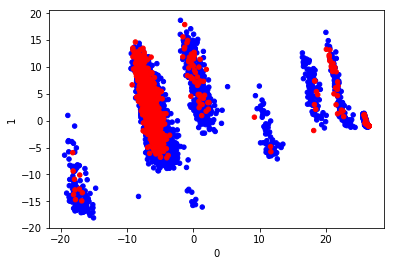

In [86]:
zeros = pd.DataFrame(np.zeros((azdias_rows, 1)))
ones = pd.DataFrame(np.ones((cust_rows, 1)))

RESPONSE = pd.concat([zeros, ones])
visualize_2D(encoded_data, RESPONSE)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [77]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
train_data, train_LNR, train_class, leftover_train = preprocessing(mailout_train)

- - - - - - - - - - - - - - - - - - - - - - - - - 
Replacing all "NaN" with -1 ...
Done replacing "NaN" values.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Extracting customer identification numbers ...
Done extracting customer IDs.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Splitting data into categorical, non-categorical, and unknown ...
Done splitting data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Mapping non-categorical data to new values ...
      147  columns were left untouched.
Done mapping non-categorical data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Converting categorical values to one-hot encodings ...
Done creating one-hot encodings.
-------------------------
Not processing data of unknown type (categorical/non-categorical).
-------------------------
Recombining all data back into one cleaned, mapped, and encoded dataframe ...
Done combining into one dataframe.
-------------------------


In [79]:
train_data.drop(columns = ['RESPONSE'], inplace = True)  # Captures all data but 'RESPONSE' column of dataframe turned np array

Scaling dataframe mean and standard deviation ...
Done scaling dataframe.
-------------------------
Projecting features onto 2-dimensional sub-space for easy visualization ...
Done projecting onto 2-dimensional sub-space.
-------------------------
Total retained variance:  36.6195997742 %
-------------------------
See below table for % variance contribution of each feature to the two principal components (PC-1, PC-2).
-------------------------
      ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  ANZ_TITEL  BALLRAUM  \
PC-1             1.592101      5.687429      5.086641   7.073880  5.484414   
PC-2             7.408771      1.711998     10.294016   0.594607  3.691484   

      D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  \
PC-1           0.831828           1.012148          1.425329   
PC-2           7.578677           8.472516         10.141527   

      D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM    ...     \
PC-1                  0.692142                 1.109850

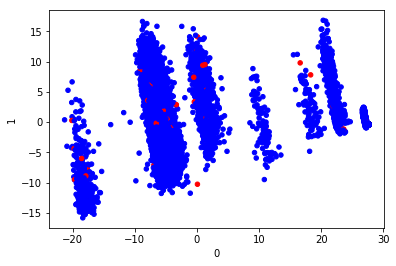

In [90]:
visualize_2D(train_data, pd.DataFrame(mailout_train['RESPONSE']))

## Benchmark Model

In [92]:
lr = LogisticRegression()
lr.fit(train_data, mailout_train['RESPONSE'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
train_predictions = lr.predict_proba(train_data)[:,1]
print("Area Under Curve for train set predictions: ", roc_auc_score(mailout_train['RESPONSE'], train_predictions))

Area Under Curve for train set predictions:  0.817786770426


## My Model

In [102]:
param_distributions={'max_depth': sp.stats.randint(1, 500),
                             'subsample': sp.stats.uniform(0.05, .95),
                             'colsample_bytree': sp.stats.uniform(0.05, .95),
                             'bagging_fraction': sp.stats.uniform(0.05, .95),
                             'bagging_freq': sp.stats.randint(1, 200),
                             'max_bin': sp.stats.randint(2, 1000),
                             'boosting': ["dart", "gbdt", "rf"],
                             'min_data_in_leaf': sp.stats.randint(1,500)                             
        }
model = lgb.LGBMClassifier(metric = 'auc')

lgb_rs = RandomizedSearchCV(model,
                        param_distributions,
                        cv=3,
                        n_iter=200,
                        scoring="roc_auc",
                        n_jobs=-1,
                        verbose=2)
lgb_rs.fit(train_data, mailout_train['RESPONSE']) 


Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161 
[CV]  bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161, total=   7.1s
[CV] bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV]  bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161, total=   6.3s
[CV] bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161 
[CV]  bagging_fraction=0.937536749519, bagging_freq=154, boosting=gbdt, colsample_bytree=0.309313555992, max_bin=309, max_depth=242, min_data_in_leaf=370, subsample=0.678132606161, total=   6.3s
[CV] bagging_fraction=0.881908751626, bagging_freq=146, boosting=dart, colsample_bytree=0.179786984216, max_bin=626, max_depth=152, min_data_in_leaf=172, subsample=0.944734075563 
[CV]  bagging_fraction=0.881908751626, bagging_freq=146, boosting=dart, colsample_bytree=0.179786984216, max_bin=626, max_depth=152, min_data_in_leaf=172, subsample=0.944734075563, total=   6.2s
[CV] bagging_fraction=0.881908751626, bagging_freq=146,

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 60.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            metric='auc', min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ff52590fbe0>,
                                        'min_

In [103]:
train_predictions = lgb_rs.predict_proba(train_data)[:,1]
print("Area Under Curve for train set predictions: ", roc_auc_score(mailout_train['RESPONSE'], train_predictions))

Area Under Curve for train set predictions:  0.85563032611


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [104]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [105]:
test_data, test_LNR, test_class, __ = preprocessing(mailout_test)

- - - - - - - - - - - - - - - - - - - - - - - - - 
Replacing all "NaN" with -1 ...
Done replacing "NaN" values.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Extracting customer identification numbers ...
Done extracting customer IDs.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Splitting data into categorical, non-categorical, and unknown ...
Done splitting data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Mapping non-categorical data to new values ...
      147  columns were left untouched.
Done mapping non-categorical data.
- - - - - - - - - - - - - - - - - - - - - - - - - 
Converting categorical values to one-hot encodings ...
Done creating one-hot encodings.
-------------------------
Not processing data of unknown type (categorical/non-categorical).
-------------------------
Recombining all data back into one cleaned, mapped, and encoded dataframe ...
Done combining into one dataframe.
-------------------------


In [106]:
predict = lgb_rs.predict_proba(test_data)
test_predictions = predict[:, 1] 

In [107]:
LNR_predictions = pd.DataFrame(test_LNR)
LNR_predictions['RESPONSE'] = test_predictions

In [108]:
LNR_predictions.to_csv('predictions.csv', index = False)

In [113]:
joblib.dump(lgb_rs.best_estimator_, 'lgb_model.pkl', compress = 1)

['lgb_model.pkl']